In [1]:
import diff_gaussian_rasterization
import torch
import numpy as np
import pyquaternion
import os
import math
import matplotlib.pyplot as plt
# cuda_launch_blocking = True
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


ImportError: /home/govind/projects/diff-gaussian-rasterization/diff_gaussian_rasterization/_C.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb

In [ ]:
torch.__version__

'1.13.0+cu117'

In [ ]:
device = torch.device("cuda")

# generate a random point cloud
N = 1000
means3D = torch.rand(N, 3, dtype=torch.float32, device=device) * 4 - 2
means2D = torch.zeros(N, 2, dtype=torch.float32, device=device)
opacities = torch.ones(N, 1, dtype=torch.float32, device=device)
scales = torch.ones(N, 3, dtype=torch.float32, device=device) * 0.1
rotations = torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)])).to(torch.float32).to(device)
colors_precomp = torch.rand(N, 3, dtype=torch.float32, device=device)


In [ ]:
# generate the projection matrix (orthographic)

def gen_orthographic_matrix(left: float, right: float, bottom: float, top: float, near: float, far: float):
    """Generate orthographic projection matrix.

    Args:
        left (float): left plane
        right (float): right plane
        bottom (float): bottom plane
        top (float): top plane
        near (float): near plane
        far (float): far plane

    Returns:
        torch.Tensor: orthographic projection matrix
    """
    return torch.tensor([
        [2 / (right - left), 0, 0, -(right + left) / (right - left)],
        [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
        [0, 0, -2 / (far - near), -(far + near) / (far - near)],
        [0, 0, 0, 1],
    ])

In [ ]:
FoVx = 90
FoVy = 90

raster_settings = diff_gaussian_rasterization.GaussianRasterizationSettings(
    image_height=512,
    image_width=512,
    tanfovx=math.tan(FoVx * 0.5),
    tanfovy=math.tan(FoVy * 0.5),
    bg=torch.zeros(4, dtype=torch.float32, device=device),
    scale_modifier=1.0,
    viewmatrix=torch.eye(4, dtype=torch.float32, device=device),
    projmatrix=gen_orthographic_matrix(-1, 1, -1, 1, 0.1, 10).to(device),
    sh_degree=1,
    campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
    prefiltered=False,
    debug=True,
)

In [ ]:
rasterizer = diff_gaussian_rasterization.GaussianRasterizer(raster_settings=raster_settings)


In [ ]:
print("means3D", means3D.shape)
print("means2D", means2D.shape)
print("scales", scales.shape)
print("rotations", rotations.shape)
print("opacities", opacities.shape)
print("colors_precomp", colors_precomp.shape)

means3D torch.Size([1000, 3])
means2D torch.Size([1000, 2])
scales torch.Size([1000, 3])
rotations torch.Size([1000, 4])
opacities torch.Size([1000, 1])
colors_precomp torch.Size([1000, 3])


In [ ]:
rendered_image, radii = rasterizer(
    means3D=means3D,
    means2D=means2D,
    colors_precomp=colors_precomp,
    opacities=opacities,
    scales=scales,
    rotations=rotations,
)

radii device: cuda:0
means3D device: 0
means3D type: 2
idx: 992
idx: 993
idx: 994
idx: 995
idx: 996
idx: 997
idx: 998
idx: 999
idx: 896
idx: 897
idx: 898
idx: 899
idx: 900
idx: 901
idx: 902
idx: 903
idx: 904
idx: 905
idx: 906
idx: 907
idx: 908
idx: 909
idx: 910
idx: 911
idx: 912
idx: 913
idx: 914
idx: 915
idx: 916
idx: 917
idx: 918
idx: 919
idx: 920
idx: 921
idx: 922
idx: 923
idx: 924
idx: 925
idx: 926
idx: 927
idx: 864
idx: 865
idx: 866
idx: 867
idx: 868
idx: 869
idx: 870
idx: 871
idx: 872
idx: 873
idx: 874
idx: 875
idx: 876
idx: 877
idx: 878
idx: 879
idx: 880
idx: 881
idx: 882
idx: 883
idx: 884
idx: 885
idx: 886
idx: 887
idx: 888
idx: 889
idx: 890
idx: 891
idx: 892
idx: 893
idx: 894
idx: 895
idx: 544
idx: 545
idx: 546
idx: 547
idx: 548
idx: 549
idx: 550
idx: 551
idx: 552
idx: 553
idx: 554
idx: 555
idx: 556
idx: 557
idx: 558
idx: 559
idx: 560
idx: 561
idx: 562
idx: 563
idx: 564
idx: 565
idx: 566
idx: 567
idx: 568
idx: 569
idx: 570
idx: 571
idx: 572
idx: 573
idx: 574
idx: 575
idx: 608


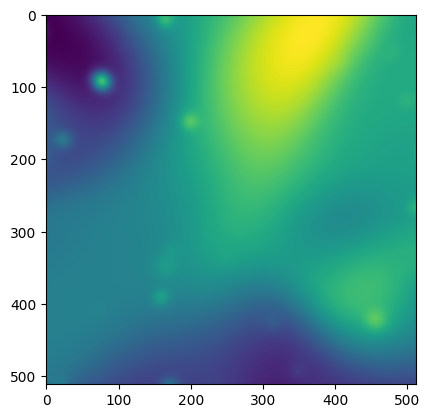

In [ ]:
rendered_image_cpu = rendered_image.cpu().numpy()

# display the rendered image
plt.imshow(rendered_image_cpu[0])